# Importing packages

In [ ]:
import os
from os.path import join
from pathlib import Path
import glob

import random
import numpy as np 
import pandas as pd

from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import matplotlib.pyplot as plt

In [ ]:
def set_random_seed(rs):
    torch.manual_seed(rs)
    random.seed(rs)
    np.random.seed(rs)

In [ ]:
'''
from collections import OrderedDict
from torch import nn
from __future__ import print_function, division

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
''';

In [ ]:
rs = 76

# Loading dataset from Kagle

In [ ]:
from google.colab import drive
drive._mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


Переходим в рабочую директорию проекта

In [ ]:
%cd "/content/gdrive/MyDrive/NSU-DNN_Course/In_the_blue_sea_white_foam"

/content/gdrive/MyDrive/NSU-DNN_Course/In_the_blue_sea_white_foam


In [ ]:
!ls

 a-large-scale-fish-dataset.zip   non-augmented_train_data.csv
 Fish_Dataset			  non-augmented_val_data.csv
 kaggle.json			  README.txt
 labels_decoder.csv		  Segmentation_example_script.m
 license.txt			  Went_to_the_bottom.ipynb
 NA_Fish_Dataset		 'Кодирование классов.ipynb'
 non-augmented_test_data.csv


При первом запуске - скачиваем данные с kagle  
Далее работаю с неагментированным набором, поэтому и проверяю его наличие здесь  


Для os.environ["KAGGLE_CONFIG_DIR"] требуется указать полный путь до директории с файлом kaggle.json

In [ ]:
if "NA_Fish_Dataset" not in os.listdir():
    print("Downloading fish datasets from kaggle")
    !pip install kaggle
    os.environ["KAGGLE_CONFIG_DIR"] = "/content/gdrive/MyDrive/NSU-DNN_Course/In_the_blue_sea_white_foam"
    !kaggle datasets download -d crowww/a-large-scale-fish-dataset
    !unzip a-large-scale-fish-dataset.zip
else: 
    print("Fish dataset has already been downloaded")

Fish dataset has already been downloaded


In [ ]:
!ls

 a-large-scale-fish-dataset.zip   non-augmented_train_data.csv
 Fish_Dataset			  non-augmented_val_data.csv
 kaggle.json			  README.txt
 labels_decoder.csv		  Segmentation_example_script.m
 license.txt			  Went_to_the_bottom.ipynb
 NA_Fish_Dataset		 'Кодирование классов.ipynb'
 non-augmented_test_data.csv


# Data preprocessing


Прежде всего требуется создать файл с наименованием всех изображений и их лейблов  
UPD: В этом блоке разбила на 3 набора

In [ ]:
main_dir = Path(join('.', "NA_Fish_Dataset")) 
file_paths = list(
                filter(
                    lambda file_patch: any([ext in str(file_patch).lower() for ext in ['png', 'jpg']]),
                    main_dir.glob(join("**", r"*.*"))
                )
            )
del main_dir
labels = list(
            map(
                lambda file_path: os.path.split(os.path.split(file_path)[0])[1],
                file_paths
            )
        )

Картинки в sea bass и red sea bream - JPG


In [ ]:
file_paths = pd.Series(file_paths, name="file path", dtype=str)
labels = pd.Series(labels, name="label", dtype=str)

imgs_df = pd.merge(file_paths, labels, right_index=True, left_index=True) # Объединяем по индексам
del file_paths, labels
imgs_df.sample(n=5, random_state=rs)

,file path,label
343,NA_Fish_Dataset/Shrimp/00045.png,Shrimp
193,NA_Fish_Dataset/Red Mullet/00041.png,Red Mullet
407,NA_Fish_Dataset/Trout/00013.png,Trout
388,NA_Fish_Dataset/Striped Red Mullet/00050.png,Striped Red Mullet
195,NA_Fish_Dataset/Red Mullet/00038.png,Red Mullet


## Label Encoding

In [ ]:
labels_decoder_dict = dict(enumerate(imgs_df["label"].unique()))
labels_encoder_dict = dict(zip(labels_decoder_dict.values(), labels_decoder_dict.keys()))
labels_encoder_dict

{'Black Sea Sprat': 0,
 'Gilt Head Bream': 1,
 'Horse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

In [ ]:
labels_decoder_pd = pd.DataFrame.from_dict(labels_decoder_dict,  orient="index", columns=["class_name"])
labels_decoder_pd.to_csv(join('.', "labels_decoder.csv"), index=True)
del labels_decoder_dict
labels_decoder_pd

,class_name
0,Black Sea Sprat
1,Gilt Head Bream
2,Horse Mackerel
3,Red Mullet
4,Red Sea Bream
5,Sea Bass
6,Shrimp
7,Striped Red Mullet
8,Trout


In [ ]:
del labels_decoder_pd

In [ ]:
imgs_df["label"].replace(to_replace=labels_encoder_dict, inplace=True)
imgs_df.sample(n=5, random_state=rs)

,file path,label
343,NA_Fish_Dataset/Shrimp/00045.png,6
193,NA_Fish_Dataset/Red Mullet/00041.png,3
407,NA_Fish_Dataset/Trout/00013.png,8
388,NA_Fish_Dataset/Striped Red Mullet/00050.png,7
195,NA_Fish_Dataset/Red Mullet/00038.png,3


In [ ]:
del labels_encoder_dict

In [ ]:
imgs_df.shape # (429, 2)

(429, 2)

In [ ]:
labels_decoder_pd = pd.read_csv(join('.', "labels_decoder.csv"), index_col=0)
labels_decoder_pd

,class_name
0,Black Sea Sprat
1,Gilt Head Bream
2,Horse Mackerel
3,Red Mullet
4,Red Sea Bream
5,Sea Bass
6,Shrimp
7,Striped Red Mullet
8,Trout


## Label One-Hot Encoding

In [ ]:
imgs_df.merge(right=pd.get_dummies(imgs_df["label"]), left_index=True, right_index=True)

,file path,label,0,1,2,3,4,5,6,7,8
0,NA_Fish_Dataset/Black Sea Sprat/00032.png,0,1,0,0,0,0,0,0,0,0
1,NA_Fish_Dataset/Black Sea Sprat/00008.png,0,1,0,0,0,0,0,0,0,0
2,NA_Fish_Dataset/Black Sea Sprat/00046.png,0,1,0,0,0,0,0,0,0,0
3,NA_Fish_Dataset/Black Sea Sprat/00040.png,0,1,0,0,0,0,0,0,0,0
4,NA_Fish_Dataset/Black Sea Sprat/00026.png,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
424,NA_Fish_Dataset/Trout/00019.png,8,0,0,0,0,0,0,0,0,1
425,NA_Fish_Dataset/Trout/00027.png,8,0,0,0,0,0,0,0,0,1
426,NA_Fish_Dataset/Trout/00021.png,8,0,0,0,0,0,0,0,0,1
427,NA_Fish_Dataset/Trout/00024.png,8,0,0,0,0,0,0,0,0,1


# Epilogue: num_workers in DataLoader

Читаем документацию:

When a subclass is used with DataLoader, each item in the dataset will be yielded from the DataLoader iterator. When num_workers > 0, each worker process will have a different copy of the dataset object, so it is often desired to configure each copy independently to avoid having duplicate data returned from the workers. get_worker_info(), when called in a worker process, returns information about the worker. It can be used in either the dataset’s __iter__() method or the DataLoader ‘s worker_init_fn option to modify each copy’s behavior.

На этом моменте я подумала, что если я не определяю никакого поведения в своем кастомном классе для дейтасета для параллельных потоков, то каждый из потоков будет иметь копию данных

Тестируемся на примере из https://pytorch.org/docs/stable/data.html

In [ ]:
import math
class MyIterableDataset(torch.utils.data.IterableDataset):
    def __init__(self, start, end):
        super(MyIterableDataset).__init__()
        assert end > start, "this example code only works with end >= start"
        self.start = start
        self.end = end
    def __iter__(self):
        return iter(range(self.start, self.end))
# should give same set of data as range(3, 7), i.e., [3, 4, 5, 6].
ds = MyIterableDataset(start=3, end=7)

# Single-process loading
print(list(torch.utils.data.DataLoader(ds, num_workers=0)))
# Directly doing multi-process loading yields duplicate data
print(list(torch.utils.data.DataLoader(ds, num_workers=2)))

# Define a `worker_init_fn` that configures each dataset copy differently
def worker_init_fn(worker_id):
    worker_info = torch.utils.data.get_worker_info()
    dataset = worker_info.dataset  # the dataset copy in this worker process
    overall_start = dataset.start
    overall_end = dataset.end
    # configure the dataset to only process the split workload
    per_worker = int(math.ceil((overall_end - overall_start) / float(worker_info.num_workers)))
    worker_id = worker_info.id
    dataset.start = overall_start + worker_id * per_worker
    dataset.end = min(dataset.start + per_worker, overall_end)

# Mult-process loading with the custom `worker_init_fn`
# Worker 0 fetched [3, 4].  Worker 1 fetched [5, 6].
print(list(torch.utils.data.DataLoader(ds, num_workers=2, worker_init_fn=worker_init_fn)))

# With even more workers
print(list(torch.utils.data.DataLoader(ds, num_workers=20, worker_init_fn=worker_init_fn)))

[tensor([3]), tensor([4]), tensor([5]), tensor([6])]
[tensor([3]), tensor([3]), tensor([4]), tensor([4]), tensor([5]), tensor([5]), tensor([6]), tensor([6])]
[tensor([3]), tensor([5]), tensor([4]), tensor([6])]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[tensor([3]), tensor([4]), tensor([5]), tensor([6])]


Действительно, во втором случае все 2 потока работают с одними и теми же данными. Проверим на наших рыбах: мы можем использовать это, для уменьшения коэффициента аугментации (nextend). Т.е. вместо того, чтобы проходить по наборам данным 32 раза, чтобы получить полный аугментированный набор, я 16 раз запущу по 2 параллельных потока по обучающему набору.  

0 torch.Size([1, 3, 224, 224]) torch.Size([1])
labels: ['Black Sea Sprat']
1 torch.Size([1, 3, 224, 224]) torch.Size([1])
labels: ['Black Sea Sprat']


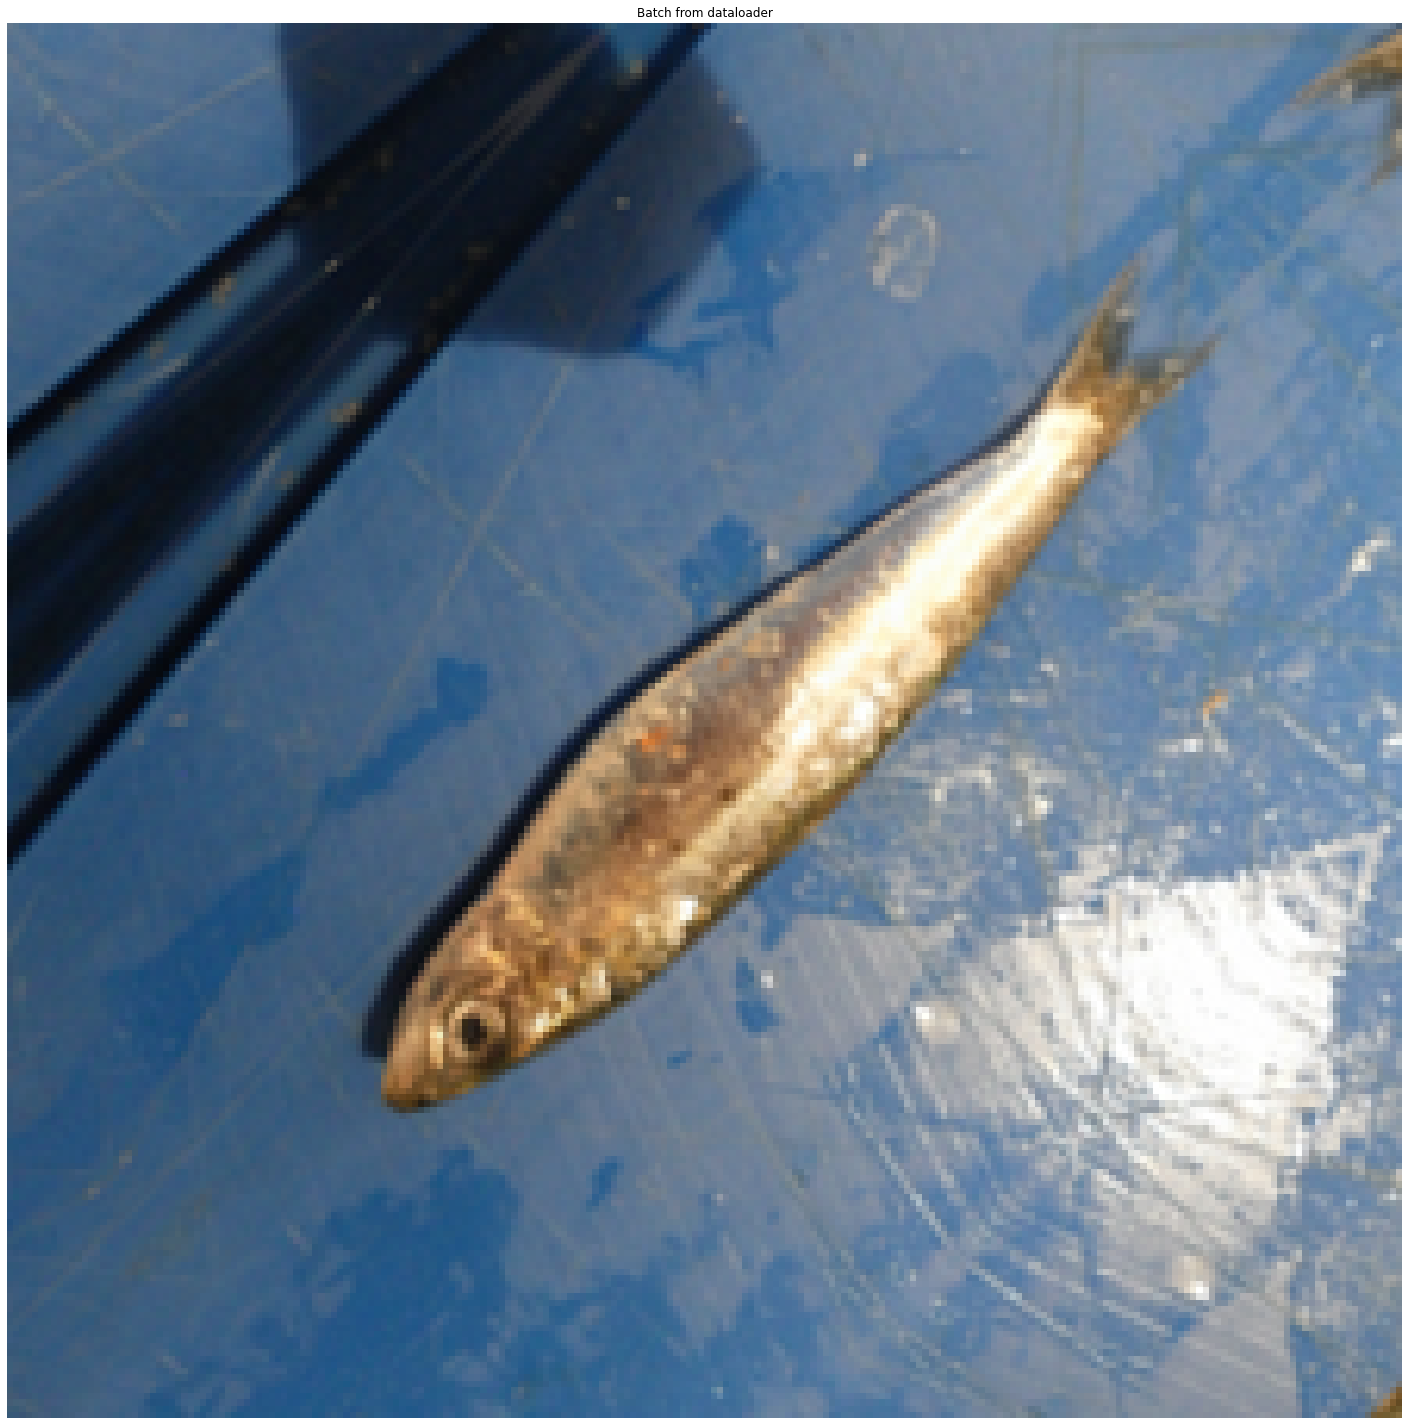

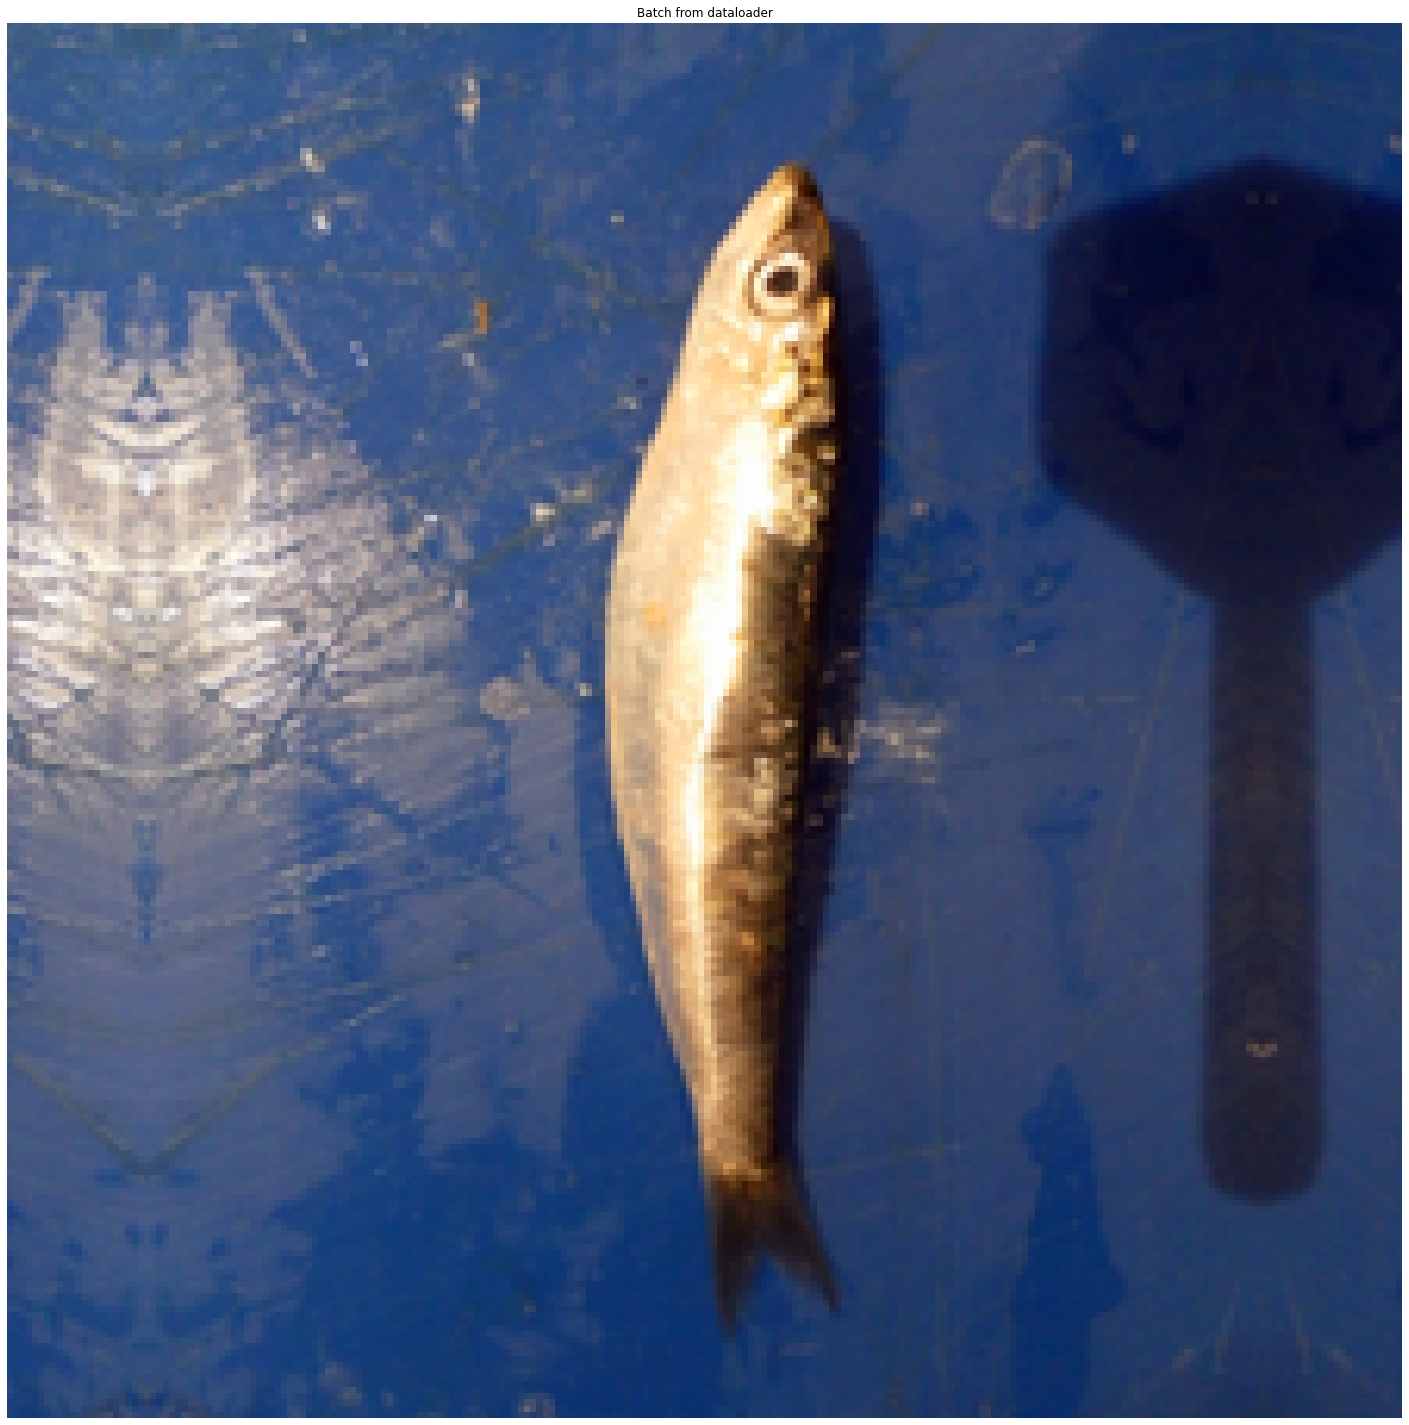

In [ ]:
#%%script false
set_random_seed(rs)
train_imgs_dataset = Multiclass_Dataset(csv_file_patch=join('.', "non-augmented_train_data.csv"), imgs_transforms=imgs_transforms2)
train_dataloader = DataLoader(train_imgs_dataset, num_workers=2)
show_some_data_samples(train_dataloader, labels_decoder_s, 2)

In [ ]:
np.array(list(train_dataloader))[:4].shape

(4,)

In [ ]:
del train_imgs_dataset, train_dataloader